# Analyse the Visual Attention Data

In [34]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [35]:
df = pd.read_csv('./data/preprocessed_experiment_data.csv')
df = df[df["Outlier"] == False]
df = df.drop(columns=["Outlier"])
df

,ID,ProgrammingStyle,Algorithm,ResponseTime,Correctness,ClickData,TimeData
0,212,iterative,apply,66794,False,268-191 151-70 151-70 146-89 135-12 135-65 120...,10105 34435 35005 39192 47146 56587 61358 66794
1,245,iterative,apply,21078,True,156-17 174-195 129-44 131-62 141-93 141-114 14...,1123 3472 14145 14878 16035 19911 21078
2,272,iterative,apply,81561,True,188-192 104-34 132-69 149-89,16519 78023 79043 81561
3,296,iterative,apply,22825,False,160-195 122-115 148-9 138-34 140-60 132-94 153...,4194 11386 13568 14369 15567 17215 21808 22825
4,302,iterative,apply,20310,True,69-204 84-191 150-197 254-200 183-14 85-36 95-...,4193 5008 5850 6351 8856 10441 11790 13309 20310
...,...,...,...,...,...,...,...
323,213,list-comprehension,LinkedList,153552,False,42-22 65-45 51-123 81-143 111-161 100-143 50-1...,4155 9379 12561 13652 21857 23971 25078 25989 ...
324,252,list-comprehension,LinkedList,47933,True,110-12 118-37 101-117 126-142 134-170 137-190 ...,3853 4218 8660 9020 9434 9893 11026 11335 1200...
326,297,list-comprehension,LinkedList,48782,True,80-9 90-33 88-125 103-146 109-170 114-194 103-...,3545 4213 6711 7143 7700 8598 9962 10333 11843...
327,309,list-comprehension,LinkedList,55439,False,78-15 80-37 81-117 109-146 106-170 106-192 114...,3924 4856 5841 6974 7497 8040 10490 11359 1325...


In [36]:
def click_data_to_list(click_data_string):
    click_data_list = []
    for click in click_data_string.split(" "):
        click = click.split("-")
        # extract the x and y coordinates from a string via regex
        x = int(re.search(r'\d+', click[0])[0])
        y = int(re.search(r'\d+', click[1])[0])
        click_data_list.append((x, y))
    return click_data_list

In [37]:
def time_data_to_list(time_data_string):
    time_data_list = []
    for time in time_data_string.split(" "):
        time_data_list.append(float(time) / 1000)
    return time_data_list

In [38]:
df["ClickData"] = df["ClickData"].apply(lambda x: click_data_to_list(x))
df["TimeData"] = df["TimeData"].apply(lambda x: time_data_to_list(x))
df["NumberOfClicks"] = df["ClickData"].apply(lambda x: len(x))
df["AverageTimeOfClicks"] = (df["ResponseTime"] / 1000) / df["NumberOfClicks"]

In [39]:
df

,ID,ProgrammingStyle,Algorithm,ResponseTime,Correctness,ClickData,TimeData,NumberOfClicks,AverageTimeOfClicks
0,212,iterative,apply,66794,False,"[(268, 191), (151, 70), (151, 70), (146, 89), ...","[10.105, 34.435, 35.005, 39.192, 47.146, 56.58...",8,8.349250
1,245,iterative,apply,21078,True,"[(156, 17), (174, 195), (129, 44), (131, 62), ...","[1.123, 3.472, 14.145, 14.878, 16.035, 19.911,...",7,3.011143
2,272,iterative,apply,81561,True,"[(188, 192), (104, 34), (132, 69), (149, 89)]","[16.519, 78.023, 79.043, 81.561]",4,20.390250
3,296,iterative,apply,22825,False,"[(160, 195), (122, 115), (148, 9), (138, 34), ...","[4.194, 11.386, 13.568, 14.369, 15.567, 17.215...",8,2.853125
4,302,iterative,apply,20310,True,"[(69, 204), (84, 191), (150, 197), (254, 200),...","[4.193, 5.008, 5.85, 6.351, 8.856, 10.441, 11....",9,2.256667
...,...,...,...,...,...,...,...,...,...
323,213,list-comprehension,LinkedList,153552,False,"[(42, 22), (65, 45), (51, 123), (81, 143), (11...","[4.155, 9.379, 12.561, 13.652, 21.857, 23.971,...",51,3.010824
324,252,list-comprehension,LinkedList,47933,True,"[(110, 12), (118, 37), (101, 117), (126, 142),...","[3.853, 4.218, 8.66, 9.02, 9.434, 9.893, 11.02...",39,1.229051
326,297,list-comprehension,LinkedList,48782,True,"[(80, 9), (90, 33), (88, 125), (103, 146), (10...","[3.545, 4.213, 6.711, 7.143, 7.7, 8.598, 9.962...",37,1.318432
327,309,list-comprehension,LinkedList,55439,False,"[(78, 15), (80, 37), (81, 117), (109, 146), (1...","[3.924, 4.856, 5.841, 6.974, 7.497, 8.04, 10.4...",36,1.539972


## Descriptive: Get Number of Clicks per Algorithm

In [40]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
df_visual[["Algorithm", "ProgrammingStyle", "NumberOfClicks"]].groupby(["Algorithm", "ProgrammingStyle"]).describe()

NumberOfClicks                              \
                                          count       mean        std   min   
Algorithm     ProgrammingStyle                                                
LinkedList    higher-order                  5.0  39.800000  21.288495  11.0   
              iterative                     6.0  45.333333  12.785408  33.0   
              list-comprehension            7.0  41.714286  15.923926  25.0   
              recursive                     6.0  31.166667  16.129683   8.0   
apply         higher-order                  8.0   3.500000   0.755929   3.0   
              iterative                     7.0   7.142857   1.676163   4.0   
              list-comprehension            6.0   3.666667   1.211060   3.0   
              recursive                     7.0  20.571429  14.953897   6.0   
computer      higher-order                  7.0  44.142857  35.690468  18.0   
              iterative                     5.0  29.400000   4.774935  25.0   
              list-comprehension            8.0  33.125000  16.348329  19.0   
              recursive                     4.0  26.500000  16.583124   5.0   
condition_sum higher-order                  5.0   6.400000   3.209361   4.0   
              iterative                     7.0  16.857143  10.447146   8.0   
              list-comprehension            7.0   9.428571   3.457222   6.0   
              recursive                     6.0  12.500000   8.093207   6.0   
find          higher-order                  5.0  20.800000  26.499057   7.0   
              iterative                     7.0   9.714286   4.535574   6.0   
              list-comprehension            6.0   5.333333   2.422120   3.0   
              recursive                     6.0  21.500000   7.918333  12.0   
is_prime      higher-order                  7.0  13.285714  13.250337   4.0   
              iterative                     9.0  15.777778  10.732867   8.0   
              list-comprehension            5.0   2.800000   0.836660   2.0   
              recursive                     7.0  12.857143   4.220133   8.0   
max           higher-order                  8.0   7.000000   5.477226   3.0   
              iterative                     6.0  13.000000   6.782330   5.0   
              list-comprehension            7.0   8.428571   4.197505   6.0   
              recursive                     7.0  21.285714  18.364044   7.0   
node          higher-order                  7.0  34.571429  15.778225  10.0   
              iterative                     7.0  40.428571  12.594405  28.0   
              list-comprehension            5.0  36.000000  19.685020  17.0   
              recursive                     5.0  46.000000  17.818530  30.0   
prime_factors higher-order                  7.0  17.857143   8.513295   9.0   
              iterative                     6.0  23.833333   7.704977  17.0   
              list-comprehension            6.0  22.000000  32.631273   4.0   
              recursive                     6.0  51.166667  48.329770  18.0   
quad_mul      higher-order                  5.0   7.000000   1.224745   6.0   
              iterative                     8.0  13.750000   5.922114   9.0   
              list-comprehension            6.0  12.666667  11.075498   6.0   
              recursive                     6.0   5.000000   1.673320   2.0   
store         higher-order                  4.0  51.250000  23.271943  17.0   
              iterative                     6.0  56.833333  23.327380  12.0   
              list-comprehension            6.0  75.333333  36.843814  32.0   
              recursive                     6.0  63.666667  17.750117  33.0   
students      higher-order                  7.0  24.714286  16.007439  11.0   
              iterative                     3.0  22.000000   4.582576  17.0   
              list-comprehension            5.0   5.600000   3.781534   3.0   
              recursive                     6.0  26.833333  24.742002   7.0   
tota

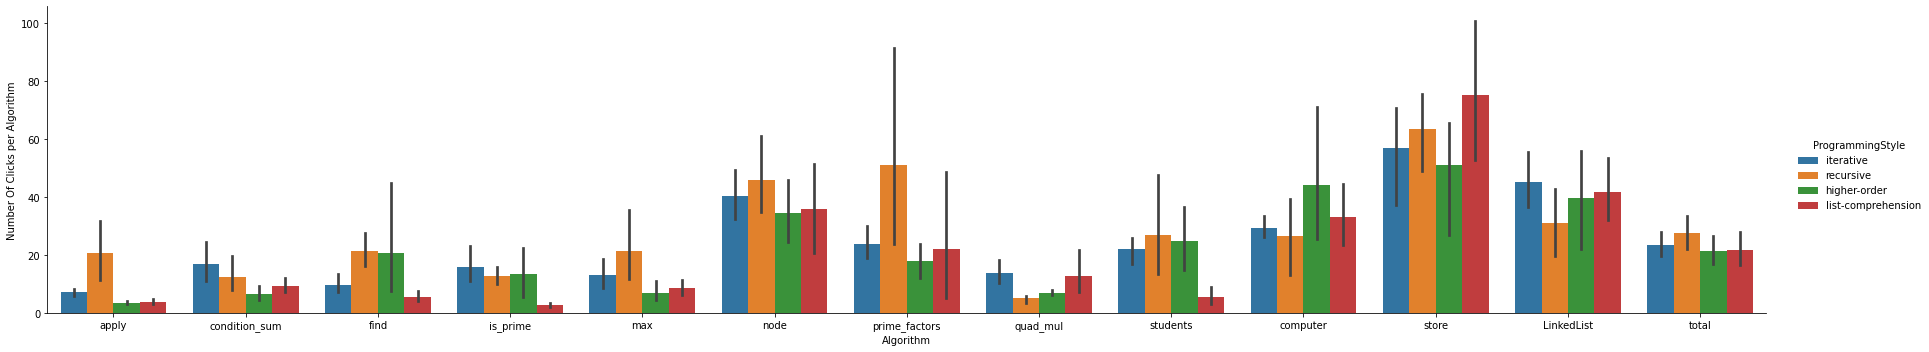

In [41]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
ax = sns.catplot(x="Algorithm", y="NumberOfClicks", hue="ProgrammingStyle", data=df_visual, kind="bar", height=5, aspect=5)
ax.tight_layout()
ax.set(ylabel='Number Of Clicks per Algorithm');

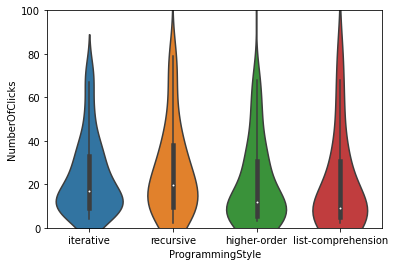

In [42]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "NumberOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.violinplot(x="ProgrammingStyle", y="NumberOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 100.0));

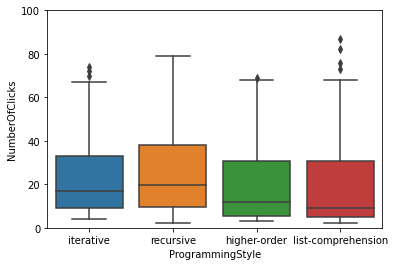

In [43]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "NumberOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.boxplot(x="ProgrammingStyle", y="NumberOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 100.0));

## Descriptive: Get Average Time of Clicks per Algorithm

In [44]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
df_visual[["Algorithm", "ProgrammingStyle", "AverageTimeOfClicks"]].groupby(["Algorithm", "ProgrammingStyle"]).describe()

AverageTimeOfClicks                        \
                                               count       mean        std   
Algorithm     ProgrammingStyle                                               
LinkedList    higher-order                       5.0   3.870583   4.786513   
              iterative                          6.0   1.322143   0.315762   
              list-comprehension                 7.0   1.666785   0.665028   
              recursive                          6.0   2.871412   3.427894   
apply         higher-order                       8.0   3.044512   2.517295   
              iterative                          7.0   5.693800   6.896022   
              list-comprehension                 6.0  15.986319  26.145068   
              recursive                          7.0   2.278829   1.593352   
computer      higher-order                       7.0   2.481384   1.274106   
              iterative                          5.0   2.561939   1.110463   
              list-comprehension                 8.0   1.847289   0.584720   
              recursive                          4.0   6.992149   9.903901   
condition_sum higher-order                       5.0   8.328353  10.568145   
              iterative                          7.0   2.245018   0.716550   
              list-comprehension                 7.0   4.055946   1.762658   
              recursive                          6.0   2.582092   0.875142   
find          higher-order                       5.0   8.156059   7.688899   
              iterative                          7.0   2.245674   1.269006   
              list-comprehension                 6.0   4.746681   2.964698   
              recursive                          6.0   2.460136   2.023651   
is_prime      higher-order                       7.0   5.863747   6.851100   
              iterative                          9.0   2.895691   2.410473   
              list-comprehension                 5.0   2.037000   0.938687   
              recursive                          7.0   3.097253   2.870054   
max           higher-order                       8.0   3.377257   2.118235   
              iterative                          6.0   2.977039   2.396996   
              list-comprehension                 7.0   2.854884   1.355707   
              recursive                          7.0   3.875878   4.335688   
node          higher-order                       7.0   1.714489   0.472124   
              iterative                          7.0   1.694089   0.846538   
              list-comprehension                 5.0   2.575038   1.994722   
              recursive                          5.0   2.018593   0.974096   
prime_factors higher-order                       7.0   5.027794   3.789875   
              iterative                          6.0   3.045216   3.042379   
              list-comprehension                 6.0  11.336141  20.253148   
              recursive                          6.0   2.865086   0.921142   
quad_mul      higher-order                       5.0   5.589538   6.248374   
              iterative                          8.0   3.340192   2.945449   
              list-comprehension                 6.0   4.506165   3.229365   
              recursive                          6.0   4.022583   3.245806   
store         higher-order                       4.0   2.185366   1.759323   
              iterative                          6.0   3.878688   6.081055   
              list-comprehension                 6.0   1.476232   0.516884   
              recursive                          6.0   1.391671   0.135009   
students      higher-order                       7.0   2.411953   1.212797   
              iterative                          3.0   1.660441   0.224074   
              list-comprehension                 5.0   1.758567   0.524705   
              recursive                          6.0   2.597528   2.746571   
total         higher-order                      75.0   

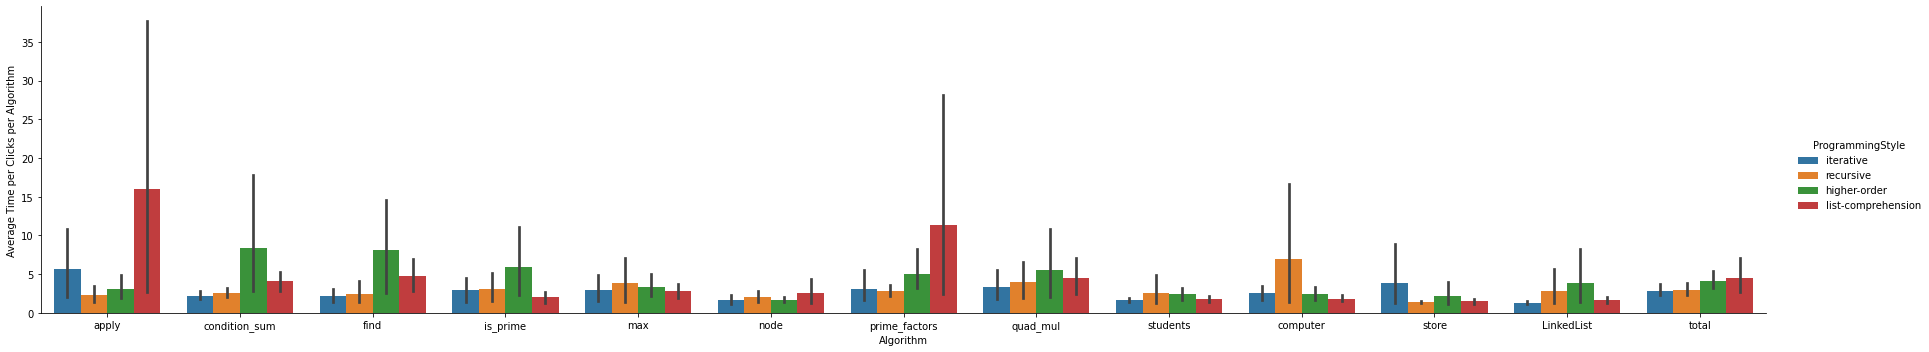

In [53]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
ax = sns.catplot(x="Algorithm", y="AverageTimeOfClicks", hue="ProgrammingStyle", data=df_visual, kind="bar", height=5, aspect=5)
ax.tight_layout()
ax.set(ylabel='Average Time per Clicks per Algorithm');

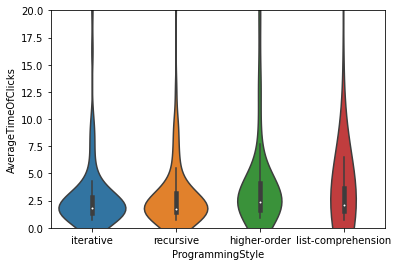

In [49]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "AverageTimeOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.violinplot(x="ProgrammingStyle", y="AverageTimeOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 20.0));

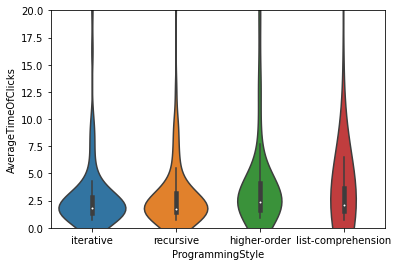

In [50]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "AverageTimeOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.violinplot(x="ProgrammingStyle", y="AverageTimeOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 20.0));